<a href="https://www.kaggle.com/code/nedadarbeheshti/grace-acc-realvssimulated?scriptVersionId=133437478" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grace-satellites-asc-files/SCA1B_2003-10-29_B_02.asc
/kaggle/input/grace-satellites-asc-files/GNV1B_2003-10-29_A_02.asc
/kaggle/input/grace-satellites-asc-files/KBR1B_2008-01-01_X_02.asc
/kaggle/input/grace-satellites-asc-files/KBR1B_2008-01-07_X_02.asc
/kaggle/input/grace-satellites-asc-files/GNV1B_2008-01-01_A_02.asc
/kaggle/input/grace-satellites-asc-files/GNV1B_2005-05-30_A_02.asc
/kaggle/input/grace-satellites-asc-files/GNV1B_2008-12-01_A_02.asc
/kaggle/input/grace-satellites-asc-files/SCA1B_2008-01-01_A_02.asc
/kaggle/input/grace-satellites-asc-files/SCA1B_2008-01-07_B_02.asc
/kaggle/input/grace-satellites-asc-files/KBR1B_2005-05-30_X_02.asc
/kaggle/input/grace-satellites-asc-files/ACC1B_2008-01-07_A_02.asc
/kaggle/input/grace-satellites-asc-files/SCA1B_2003-10-29_A_02.asc
/kaggle/input/grace-satellites-asc-files/KBR1B_2003-10-29_X_02.asc
/kaggle/input/grace-satellites-asc-files/ACC1B_2008-01-07_B_02.asc
/kaggle/input/grace-satellites-asc-files/ACC1B_2005-05-30_A_02

In [2]:
# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import Fourier, DeterministicProcess
from learntools.time_series.utils import plot_lags, make_lags, make_leads
from statsmodels.graphics.tsaplots import plot_pacf

In [3]:
real_dir = Path('../input/grace-satellites-asc-files')
simu_dir = Path('../input/grace-simulated-accelerometer-data')

In [4]:
df_A_simu = pd.read_csv(simu_dir/'ACC1B_2005-05-30_A_MDC-02.asc',header=None, sep=' ', skiprows=23)
df_B_simu = pd.read_csv(simu_dir/'ACC1B_2005-05-30_B_MDC-02.asc',header=None, sep=' ', skiprows=23)

In [5]:
df_A_real = pd.read_csv(real_dir/'ACC1B_2005-05-30_A_02.asc',header=None, sep=' ', skiprows=24)
df_B_real = pd.read_csv(real_dir/'ACC1B_2005-05-30_B_02.asc',header=None, sep=' ', skiprows=24)

In [6]:
df_A_simu.drop([1,5,6,7,8,9,10,11],axis='columns', inplace=True)
df_B_simu.drop([1,5,6,7,8,9,10,11],axis='columns', inplace=True)

In [7]:
df_A_real.drop([1,5,6,7,8,9,10,11,12],axis='columns', inplace=True)
df_B_real.drop([1,5,6,7,8,9,10,11,12],axis='columns', inplace=True)

In [8]:
df_A_simu

,0,2,3,4
0,170683200,-0.000001,0.000027,-5.486127e-07
1,170683205,-0.000001,0.000027,-5.486285e-07
2,170683210,-0.000001,0.000027,-5.486550e-07
3,170683215,-0.000001,0.000027,-5.485689e-07
4,170683220,-0.000001,0.000027,-5.485636e-07
...,...,...,...,...
17275,170769575,-0.000001,0.000027,-5.485866e-07
17276,170769580,-0.000001,0.000027,-5.485486e-07
17277,170769585,-0.000001,0.000027,-5.485400e-07
17278,170769590,-0.000001,0.000027,-5.485132e-07


In [9]:
df_A_real

,0,2,3,4
0,170683200,0.000001,-0.000029,5.458816e-07
1,170683201,0.000001,-0.000029,5.458598e-07
2,170683202,0.000001,-0.000029,5.458367e-07
3,170683203,0.000001,-0.000029,5.458131e-07
4,170683204,0.000001,-0.000029,5.457899e-07
...,...,...,...,...
86395,170769595,0.000001,-0.000029,5.385130e-07
86396,170769596,0.000001,-0.000029,5.386325e-07
86397,170769597,0.000001,-0.000029,5.387676e-07
86398,170769598,0.000001,-0.000029,5.389139e-07


In [10]:
y2_Areal = df_A_real.loc[:, 2]  # axis x target
y3_Areal = df_A_real.loc[:, 3]  # axis x target
y4_Areal = df_A_real.loc[:, 4]  # axis x target

y2_Asimu = df_A_simu.loc[:, 2]  # axis x target
y3_Asimu = df_A_simu.loc[:, 3]  # axis x target
y4_Asimu = df_A_simu.loc[:, 4]  # axis x target

In [11]:
y2_Breal = df_B_real.loc[:, 2]  # axis x target
y3_Breal = df_B_real.loc[:, 3]  # axis x target
y4_Breal = df_B_real.loc[:, 4]  # axis x target

y2_Bsimu = df_B_simu.loc[:, 2]  # axis x target
y3_Bsimu = df_B_simu.loc[:, 3]  # axis x target
y4_Bsimu = df_B_simu.loc[:, 4]  # axis x target

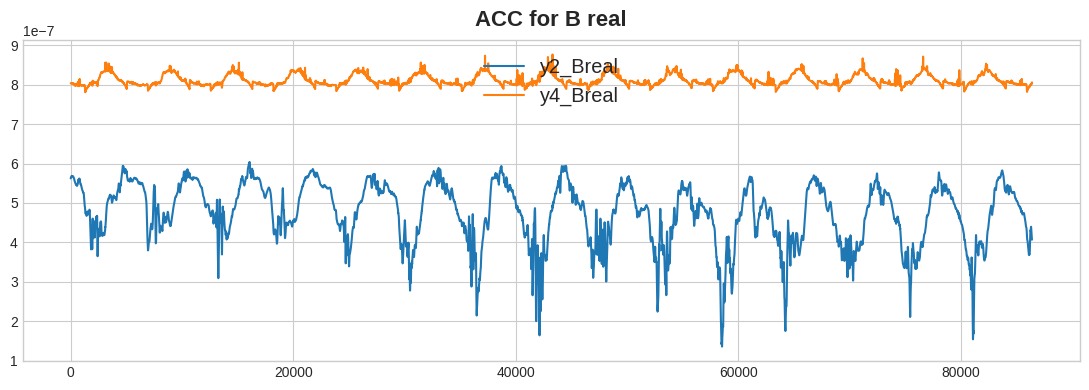

In [12]:
#plot
ax = y2_Breal.plot(label='y2_Breal')
#ax = y3_Breal.plot(label='y3_Breal')
ax = y4_Breal.plot(label='y4_Breal')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax.set_title("ACC for B real");

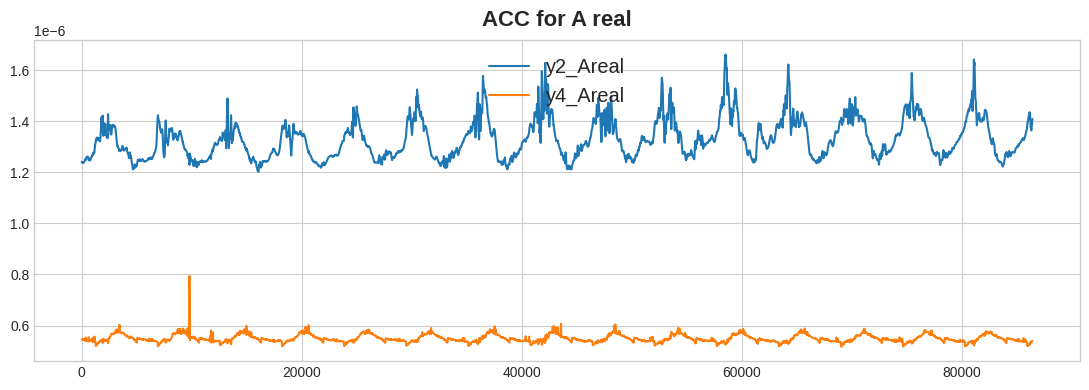

In [13]:
#plot
ax = y2_Areal.plot(label='y2_Areal')
#ax = y3_Areal.plot(label='y3_Areal')
ax = y4_Areal.plot(label='y4_Areal')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax.set_title("ACC for A real");

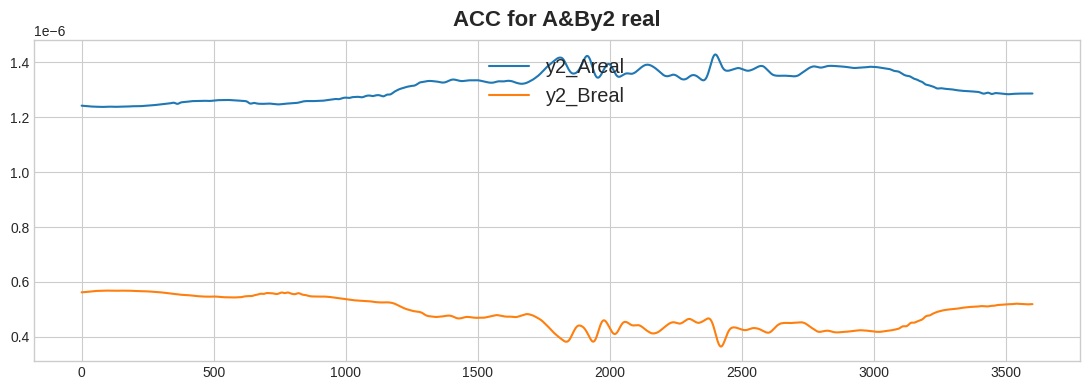

In [14]:
#plot
ax = y2_Areal[:3600].plot(label='y2_Areal')
ax = y2_Breal[:3600].plot(label='y2_Breal')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax.set_title("ACC for A&By2 real");

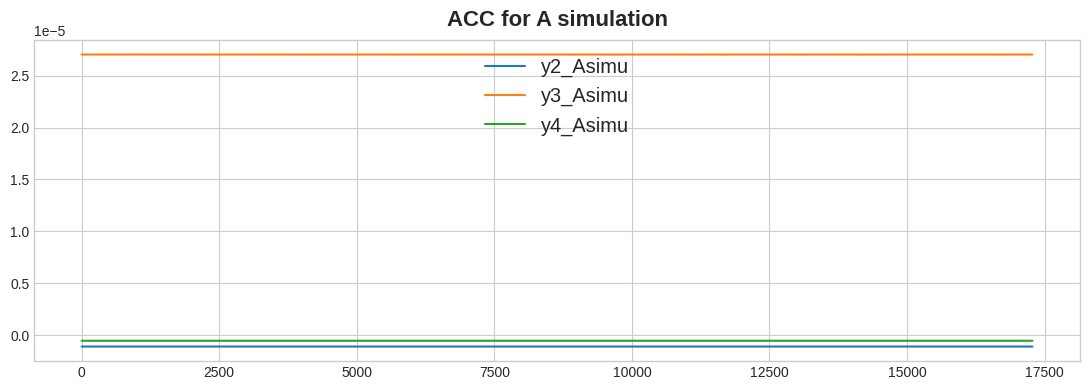

In [15]:
#plot
ax = y2_Asimu.plot(label='y2_Asimu')
ax = y3_Asimu.plot(label='y3_Asimu')
ax = y4_Asimu.plot(label='y4_Asimu')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax.set_title("ACC for A simulation");